<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Practice/pr3/Practice3_flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 144 (delta 57), reused 122 (delta 42), pack-reused 0
Receiving objects: 100% (144/144), 26.69 MiB | 39.90 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=11649 sha256=25e19809cda4a77f0e206aa934b8adf3a9705c85919568e58e7dc5d58787c6b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ltzb9cy/wheels/55/59/29/0fb1c635652157734f

In [2]:
from dul_2021.utils.pr3_utils import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta

import copy

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm import trange, tqdm_notebook

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example 1: 1D Data




<Figure size 432x288 with 0 Axes>

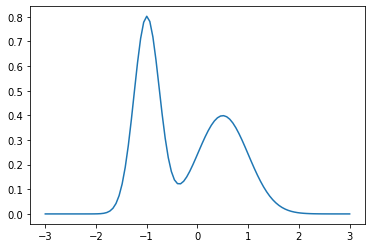

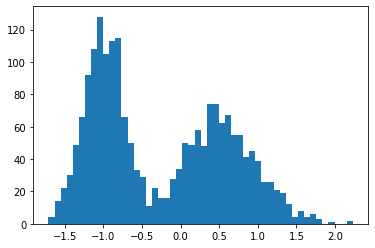

In [5]:
SEED = 69
np.random.seed(SEED)
torch.manual_seed(SEED)

n_train, n_test = 2000, 1000
train_data, test_data = load_flow_demo_1(n_train, n_test, visualize=True, train_only=False)

In [6]:
class FlowModel(nn.Module):
    def test(self, test_loader):
        self.eval()
        total_loss = 0
        tc = 0
        with torch.no_grad():
            for x in test_loader:
                x = x.to(device).float()
                loss = self.nll(x)
                total_loss += loss * x.shape[0]
                tc += x.shape[0]
        return total_loss.item() / tc

    def fit(self, train_data, test_data, num_epochs=100, 
            lr=5e-3, batch_size=128, plot=False, plot_epochs=None):
        train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = data.DataLoader(test_data, batch_size=batch_size)

        optim = opt.Adam(self.parameters(), lr=lr)

        train_losses = []
        test_losses = []

        # test_losses.append(self.test(test_loader))

        for epoch in range(num_epochs):
            for x in train_loader:
                x = x.to(device).float()
                loss = self.nll(x)
                optim.zero_grad()
                loss.backward()
                optim.step()

                train_losses.append(loss.item())
            test_losses.append(self.test(test_loader))
            if plot and epoch in plot_epochs:
                self.plot(f'Epoch {epoch}')

        if plot:
            plot_train_curves(num_epochs, train_losses, test_losses, title='Training Curve')

        return train_losses, test_losses

    def nll(self, x):
        raise NotImplementedError()

    def flow(self, x):
        raise NotImplementedError()

    def inverse(self, z):
        raise NotImplementedError()

    def log_prob(self, x):
        raise NotImplementedError()
        
    def get_density(self):
        x = np.linspace(self.plot_b[0], self.plot_b[1], 1000)
        with torch.no_grad():
            y = self.log_prob(torch.FloatTensor(x)).exp().cpu().numpy()
        return x, y

    def plot(self, title):
        density = self.get_density()
        plt.figure()
        plt.plot(density[0], density[1])
        plt.title(title)
        plt.show()

In [13]:
class CDFMixture(FlowModel):
    def __init__(self, base_dist='uniform', k=4, plot_b=(-3, 3)):
        super().__init__()
        if base_dist=='uniform':
            self.bdist = Uniform(0, 1)
        elif base_dist == 'beta':
            self.bdist = Beta(2, 2)

        self.plot_b = plot_b
        self.log_w = nn.Parameter(torch.zeros(k), requires_grad=True)
        self.mu = nn.Parameter(torch.rand(k), requires_grad=True)
        self.log_s = nn.Parameter(torch.zeros(k), requires_grad=True)

        self.k = k
    def flow(self, x):
        w = F.softmax(self.log_w, dim=0).unsqueeze(0).repeat(x.shape[0], 1)

        dist = Normal(self.mu, self.log_s.exp())

        xr  = x.unsqueeze(1).repeat(1, self.k)

        z = (dist.cdf(xr) * w).sum(dim=1)

        log_det = (dist.log_prob(xr).exp() * w).sum(dim=1).log()

        return z, log_det
    
    def inverse(self, z):
        xs = []
        for zi in z:
            def f(x):
                return flow(x.unsqueeze(0))[0] - zi
            x = bisect(f, -20, 20)
            xs.append(x)
        return x

    def log_prob(self, x):
        z, log_det = self.flow(x)
        log_prob = self.bdist.log_prob(z)
        return log_prob + log_det

    def nll(self, x):
        return -self.log_prob(x).mean()

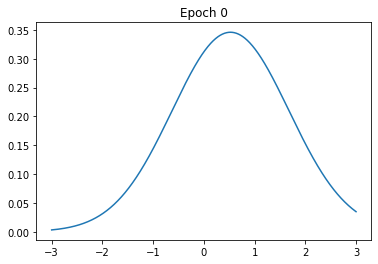

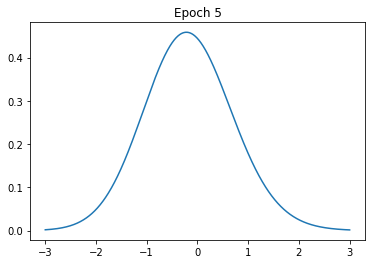

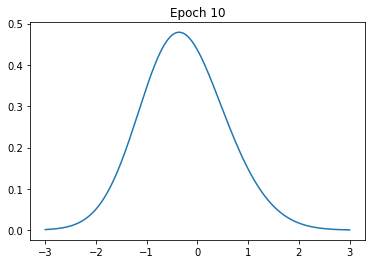

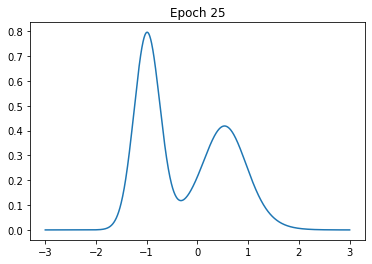

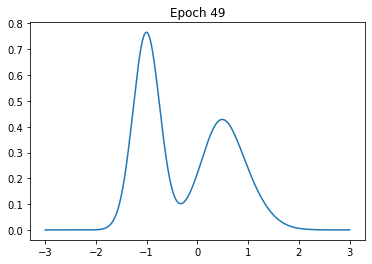

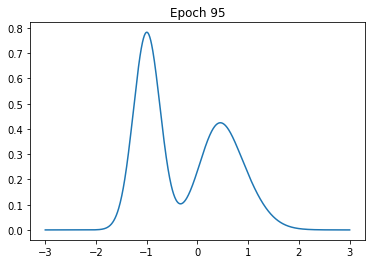

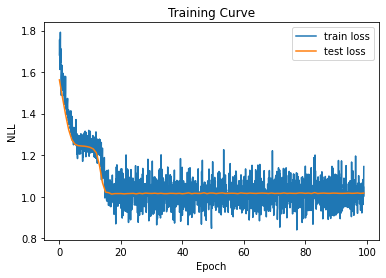

In [14]:
flow = CDFMixture(base_dist='uniform', k=5).to(device)
flow0 = copy.deepcopy(flow)
res = flow.fit(train_data, test_data, num_epochs=100, plot=True, plot_epochs=[0, 5, 10, 25, 49, 95], lr=1e-2)

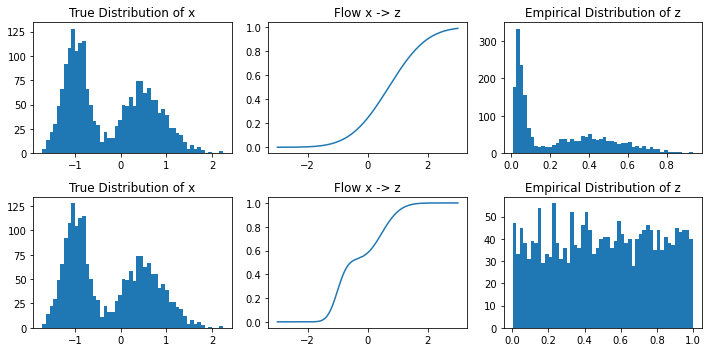

In [15]:
visualize_demo1_flow(train_data, flow0, flow)

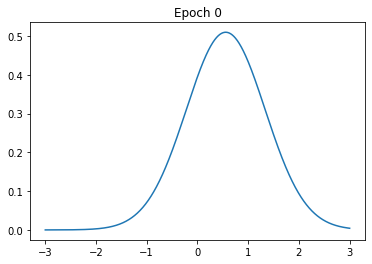

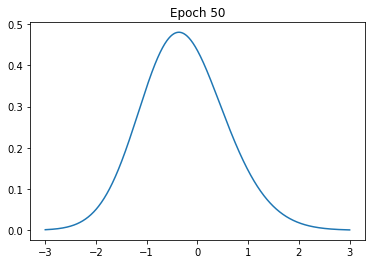

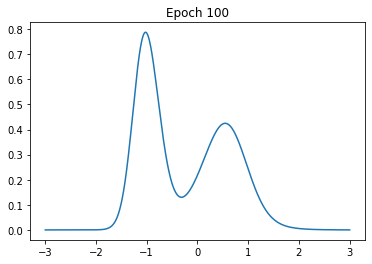

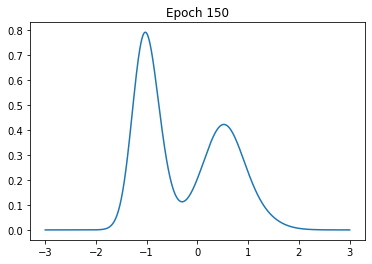

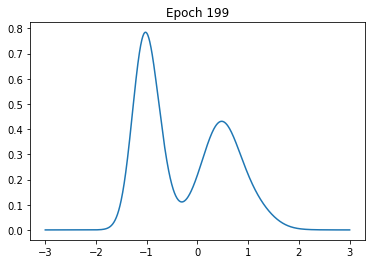

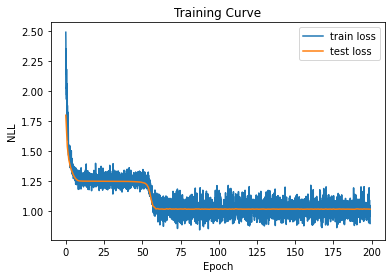

In [16]:
flow = CDFMixture(base_dist='beta', k=5).to(device)
flow0 = copy.deepcopy(flow)
res = flow.fit(train_data, test_data, num_epochs=200, plot=True, plot_epochs=[0, 50, 100, 150, 199], lr=1e-2)

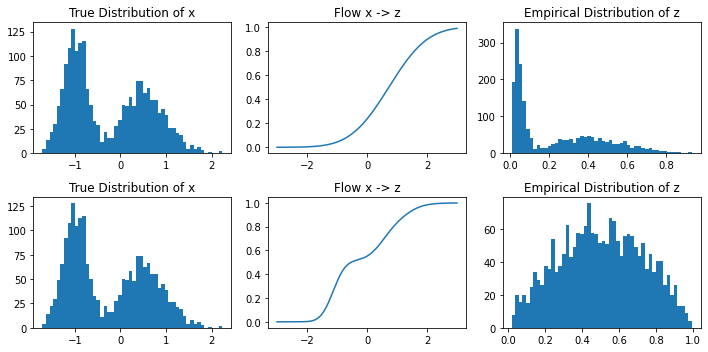

In [17]:
visualize_demo1_flow(train_data, flow0, flow)

# Example 1.5: Compostions of flows

In [18]:
class CompFlow(FlowModel):
    def __init__(self, flows, plot_b=(-3, 3)):
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.plot_b = plot_b
    
    def flow(self, x):
        z = x
        log_det = 0
        for fl in self.flows:
            z, log_det_s = fl.flow(z)
            log_det += log_det_s
        return z, log_det


    def log_prob(self, x):
        z, log_det = self.flow(x)
        log_prob = self.flows[-1].bdist.log_prob(z)
        return log_prob + log_det
    
    def nll(self, x):
        return -self.log_prob(x).mean()

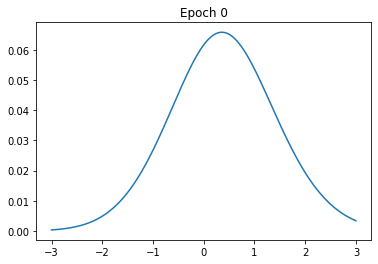

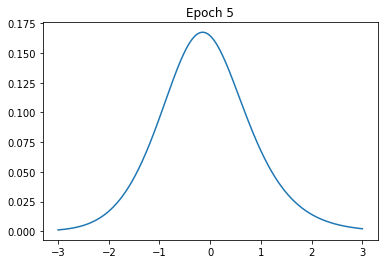

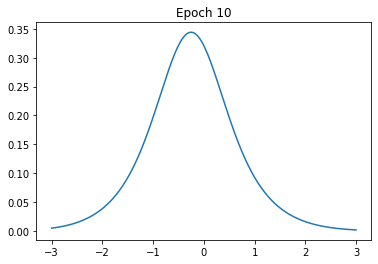

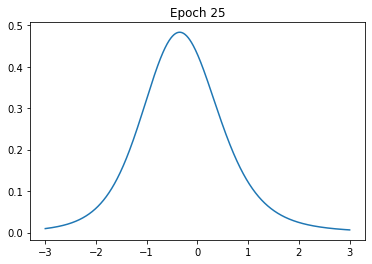

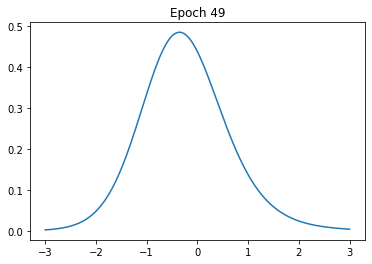

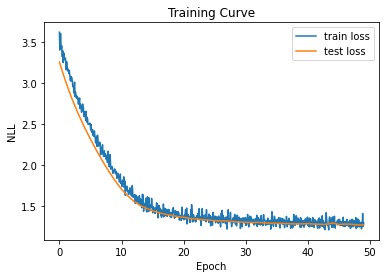

In [19]:
flow = CompFlow([CDFMixture(base_dist='uniform', k=5),
                 CDFMixture(base_dist='uniform', k=5),
                 CDFMixture(base_dist='uniform', k=5)]).to(device)
flow0 = copy.deepcopy(flow)
res = flow.fit(train_data, test_data, num_epochs=50, plot=True, plot_epochs=[0, 5, 10, 25, 49])

## better composition

A mixture of Gaussians CDF flow maps real-valued data into the unit interval $[0, 1]$. If we want to compose these flows, we need to add a "nonlinearity" that spreads mass from $[0, 1]$ back across the real numbers. Similar to how ReLUs help neural networks form complex, nonlinear functions, this "nonlinearity" can help a stack of flows model something much more complicated.

Here, we use the logit transform, which can be expressed symbolically as:
$$f(x) = \text{logit}(\alpha/2 + (1-\alpha)x)$$
where logit is the inverse of the sigmoid function. $\alpha$ controls how much this function spreads the mass back out. $\alpha=0$ spreads $[0, 1] \rightarrow \mathbb{R}$, while $\alpha = 1$ maps $[0, 1]\rightarrow \{0\}$. 

In [20]:
class LogitTransform(nn.Module):
    def __init__(self, alpha=0.1): 
        super().__init__()
        self.alpha = alpha
    
    def flow(self, x):
        xs = self.alpha / 2 + (1 - self.alpha) * x
        z = torch.log(xs) - torch.log(1 - xs)
        log_det = -torch.log(xs) - torch.log(1 - xs) + torch.log(torch.FloatTensor([1 - self.alpha]))
        return z, log_det

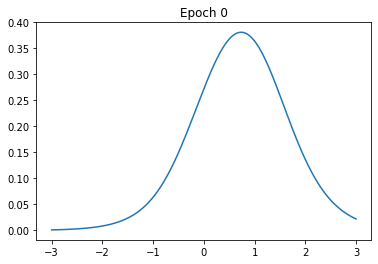

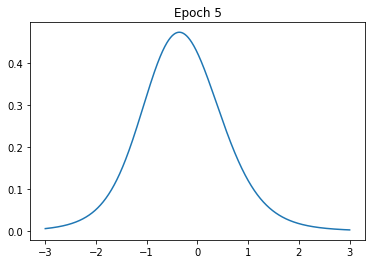

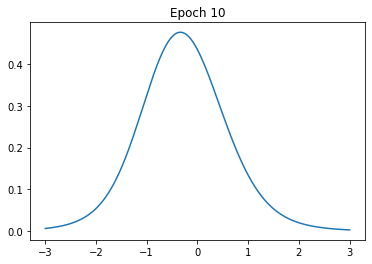

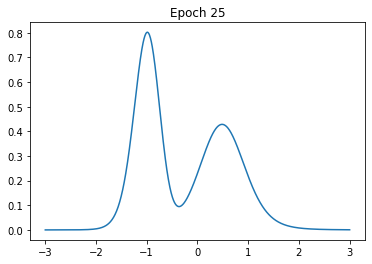

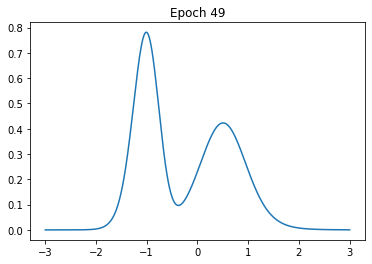

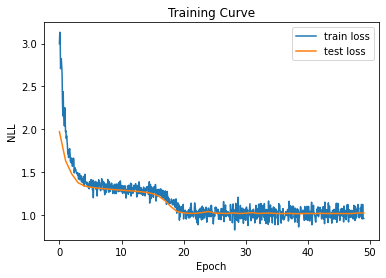

In [21]:
flow = CompFlow([CDFMixture(base_dist='uniform', k=5),
                 LogitTransform(0.2), 
                 CDFMixture(base_dist='uniform', k=5),
                 LogitTransform(0.2), 
                 CDFMixture(base_dist='uniform', k=5)]).to(device)
flow0 = copy.deepcopy(flow)
res = flow.fit(train_data, test_data, num_epochs=50, plot=True, plot_epochs=[0, 5, 10, 25, 49], lr=1e-2)

# Example 2: 2D Data


Dataset 1


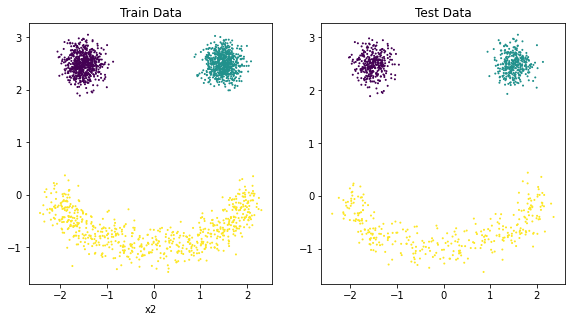

Dataset 2


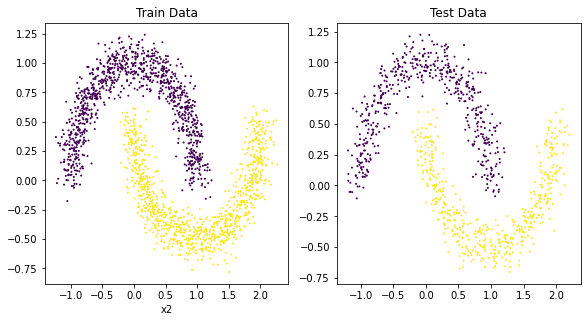

In [22]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

##Autoregressive Flow

In an autoregressive flow, we learn the transformation $z_i = f(x_i ; x_{1:i-1})$. The log-likelihood is then $\log p_\theta(x) = \sum_{i=1}^d \log p(z_i) + \log |\frac{dz_i}{dx_i}|$ because the Jacobian is triangular. For each dimension, we will use the CDF of a mixture of Gaussians or Logistics to map to the latent space, which should be $z_i \sim \text{Unif}[0, 1]$ i.i.d..

Since this is a 2D problem, we can either learn $z_0 = f(x_0)$ and $z_1 = f(x_1; x_0)$ together with a MADE model, or with separate networks. hyperparameters on a validation set of your choice.



In [23]:
class ARFlow(FlowModel):
    def __init__(self, k1=5, k2=5, hd=64):
        super().__init__()
        self.flow1 = CDFMixture(base_dist='uniform', k=k1).to(device)
        self.mlp = nn.Sequential(nn.Linear(1, hd), 
                                 nn.ReLU(), 
                                 nn.Linear(hd, hd), 
                                 nn.ReLU(),  
                                 nn.Linear(hd, k2 * 3)).to(device)

        self.k2 = k2
        self.bdist = Uniform(0., 1.)

    def flow(self, x):
        x1, x2 = torch.chunk(x, 2, dim=1)
        


        # first flow
        z1, log_det1 = self.flow1.flow(x1.squeeze())
                
        mu, log_s, log_w = torch.chunk(self.mlp(x1), 3, dim=1)

        
        w = F.softmax(log_w, dim=1)
        mix_dist = Normal(mu, log_s.exp())

        xr = x2.repeat(1, self.k2)

        z2 = (mix_dist.cdf(xr) * w).sum(dim=1)

        log_det2 = (mix_dist.log_prob(xr).exp() * w).sum(dim=1).log()

        return torch.cat([z1.unsqueeze(1), z2.unsqueeze(1)], dim=1), torch.cat([log_det1.unsqueeze(1), log_det2.unsqueeze(1)], dim=1)

    def log_prob(self, x, pr=False):
        z, log_det = self.flow(x)
        z = torch.clip(z, 0, 1)
        return (self.bdist.log_prob(z) + log_det).sum(dim=1)

    def nll(self, x):
        return - self.log_prob(x).mean()

In [24]:
def q1_a(train_data, test_data, dset_id):
  """
  train_data: An (n_train, 2) numpy array of floats in R^2
  test_data: An (n_test, 2) numpy array of floats in R^2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
  - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
      mapping the train set data points through our flow to the latent space. 
  """
  
  """ YOUR CODE HERE """


  model = ARFlow(k1=5, k2=5, hd=128)

  if dset_id == 1:  # face
      params = {'num_epochs':100, 
                'lr':5e-3, 
                'batch_size':128}
  elif dset_id == 2:  # two moons
      params = {'num_epochs':100, 
                'lr':5e-3, 
                'batch_size':128}
  # train
  train_losses, test_losses = model.fit(train_data, test_data, **params)

  # heatmap
  dx, dy = 0.025, 0.025
  if dset_id == 1:  # face
      x_lim = (-4, 4)
      y_lim = (-4, 4)
  elif dset_id == 2:  # two moons
      x_lim = (-1.5, 2.5)
      y_lim = (-1, 1.5)
  y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                  slice(x_lim[0], x_lim[1] + dx, dx)]
  mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
  densities = np.exp(model.log_prob(mesh_xs, pr=True).cpu().detach().numpy())

  # latents

  latents = model.flow(torch.FloatTensor(train_data))[0].cpu().detach().numpy()

  return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Final Test Loss: 1.3435


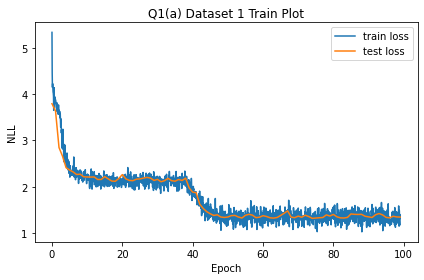

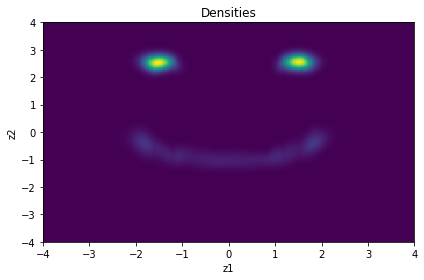

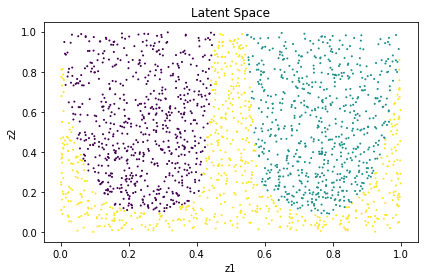

In [25]:
q1_save_results(1, 'a', q1_a)

Final Test Loss: 1.0780


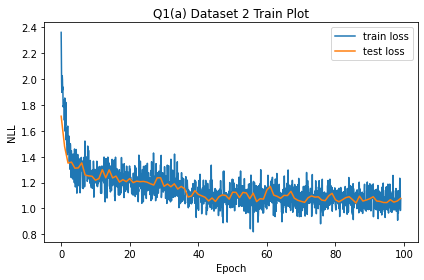

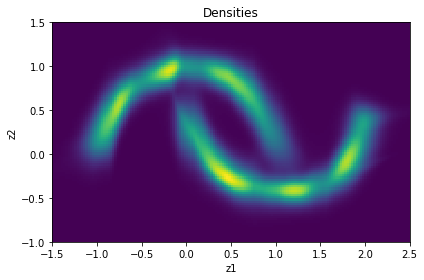

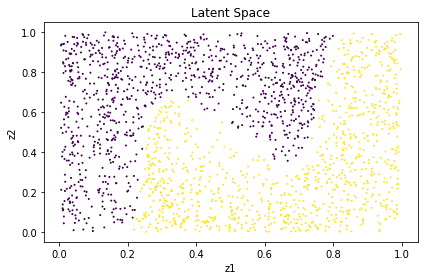

In [26]:
q1_save_results(2, 'a', q1_a)

# Example 2.5: Inverse Autoregressive flow


In [27]:
class IARFlow(FlowModel):
    def __init__(self, k1=5, k2=5, hd=64):
        super().__init__()
        self.flow1 = CDFMixture(base_dist='uniform', k=k1).to(device)
        self.mlp = nn.Sequential(nn.Linear(1, hd), 
                                 nn.ReLU(), 
                                 nn.Linear(hd, hd), 
                                 nn.ReLU(),  
                                 nn.Linear(hd, k2 * 3)).to(device)

        self.k2 = k2
        self.bdist = Uniform(0., 1.)

    def flow(self, x):
        x1, x2 = torch.chunk(x, 2, dim=1)
        


        # first flow
        z1, log_det1 = self.flow1.flow(x1.squeeze())
                
        mu, log_s, log_w = torch.chunk(self.mlp(z1.view(-1, 1)), 3, dim=1)

        
        w = F.softmax(log_w, dim=1)
        mix_dist = Normal(mu, log_s.exp())

        xr = x2.repeat(1, self.k2)

        z2 = (mix_dist.cdf(xr) * w).sum(dim=1)

        log_det2 = (mix_dist.log_prob(xr).exp() * w).sum(dim=1).log()

        return torch.cat([z1.unsqueeze(1), z2.unsqueeze(1)], dim=1), torch.cat([log_det1.unsqueeze(1), log_det2.unsqueeze(1)], dim=1)

    def log_prob(self, x, pr=False):
        z, log_det = self.flow(x)
        z = torch.clip(z, 0, 1)
        return (self.bdist.log_prob(z) + log_det).sum(dim=1)

    def nll(self, x):
        return - self.log_prob(x).mean()

In [28]:
def iq1_a(train_data, test_data, dset_id):
  """
  train_data: An (n_train, 2) numpy array of floats in R^2
  test_data: An (n_test, 2) numpy array of floats in R^2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
  - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
      mapping the train set data points through our flow to the latent space. 
  """
  
  """ YOUR CODE HERE """


  model = IARFlow(k1=5, k2=5, hd=128)

  if dset_id == 1:  # face
      params = {'num_epochs':100, 
                'lr':5e-3, 
                'batch_size':128}
  elif dset_id == 2:  # two moons
      params = {'num_epochs':100, 
                'lr':5e-3, 
                'batch_size':128}
  # train
  train_losses, test_losses = model.fit(train_data, test_data, **params)

  # heatmap
  dx, dy = 0.025, 0.025
  if dset_id == 1:  # face
      x_lim = (-4, 4)
      y_lim = (-4, 4)
  elif dset_id == 2:  # two moons
      x_lim = (-1.5, 2.5)
      y_lim = (-1, 1.5)
  y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                  slice(x_lim[0], x_lim[1] + dx, dx)]
  mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
  densities = np.exp(model.log_prob(mesh_xs, pr=True).cpu().detach().numpy())

  # latents

  latents = model.flow(torch.FloatTensor(train_data))[0].cpu().detach().numpy()

  return train_losses, test_losses, densities, latents

Final Test Loss: 1.3290


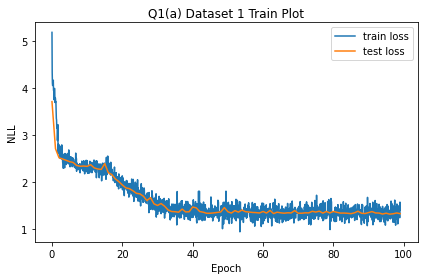

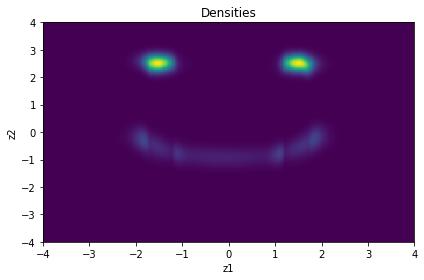

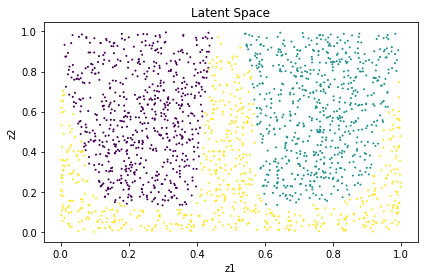

In [29]:
q1_save_results(1, 'a', iq1_a)

Final Test Loss: 1.2255


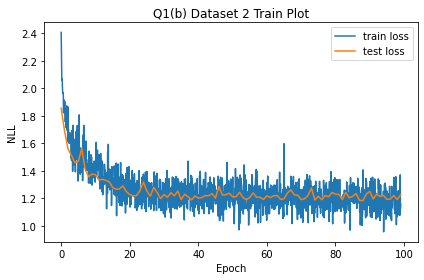

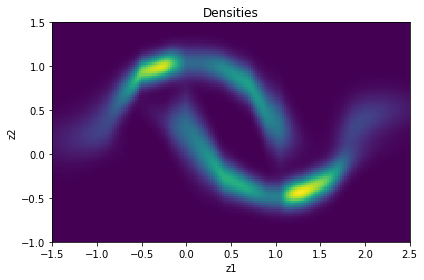

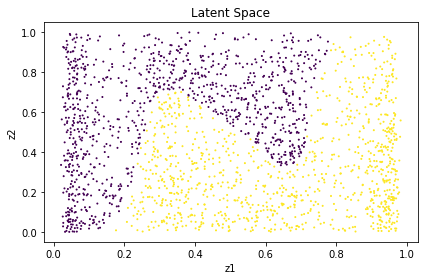

In [30]:
q1_save_results(2, 'b', iq1_a)